## Introduction
Variational Autoencoders (VAEs) are a unique type of deep learning model that, like traditional autoencoders, are composed of two primary components: an encoder and a decoder. The encoder utilizes convolutional neural networks (CNNs) and downsampling techniques to learn a compressed, probabilistic latent space that represents the input data in a lower-dimensional form. The decoder, on the other hand, leverages CNNs and upsampling methods to reconstruct the data from this latent space by sampling from the learned distribution. Unlike standard autoencoders, VAEs incorporate a regularization term that encourages the latent space to approximate a Gaussian distribution, allowing for the generation of new data points that resemble the original input. When well-trained, the VAE's decoder can produce reconstructions that are nearly indistinguishable from the original data. VAEs are commonly applied in tasks such as anomaly detection, image denoising, and data generation. In this project, we employ a VAE to colorize landscape images.

<img src = 'https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ET6FM_KEmwa2N4qgW2MglQ.png' >

## Import necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import cv2
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array

### Getting landscape image data,resizing them and appending in array
To get the image in sorted order i have defined the function sorted_alphanumeric. Here, I have used open cv library to read and resize images. Finally images are normalized and are converted to array and are appended in empty list

In [2]:
# Function to sort files alphanumerically
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Define image size
SIZE = 160

# Load and preprocess color images
color_img = []
path = '/kaggle/input/landscape-image-colorization/landscape Images/color'
files = sorted_alphanumeric(os.listdir(path))
for i in tqdm(files):
    if i == '1500.jpg':
        break
    else:
        img = cv2.imread(os.path.join(path, i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE)).astype('float32') / 255.0
        color_img.append(img_to_array(img))
# Load and preprocess grayscale images
gray_img = []
path = '/kaggle/input/landscape-image-colorization/landscape Images/gray'
files = sorted_alphanumeric(os.listdir(path))
for i in tqdm(files):
    if i == '1500.jpg':
        break
    else:
        img = cv2.imread(os.path.join(path, i), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (SIZE, SIZE)).astype('float32') / 255.0
        img = np.stack((img,)*3, axis=-1)  # Stack grayscale to match color input shape
        gray_img.append(img_to_array(img))


 21%|██        | 1500/7129 [00:14<00:52, 107.13it/s]


### Plotting Color image and it's corresponding grayscale image

In [3]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)

    plt.show()

**Plotting image pair**

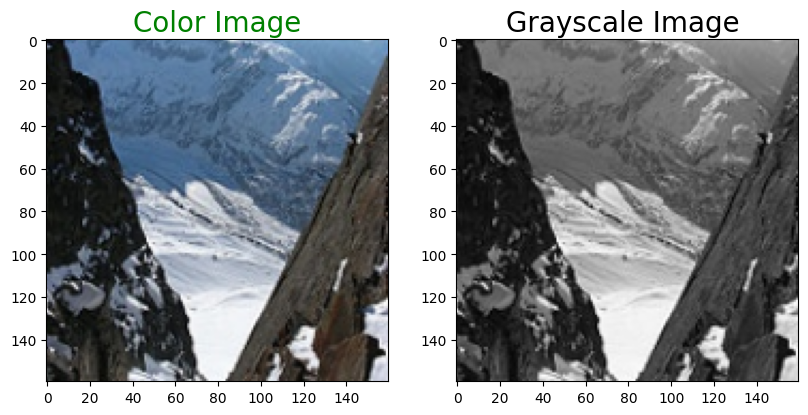

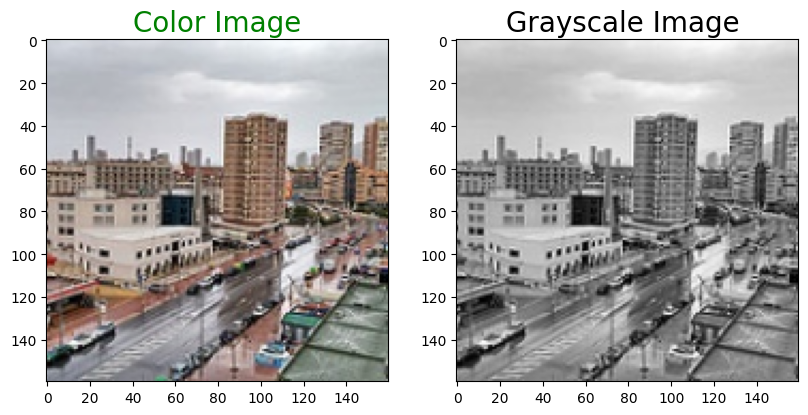

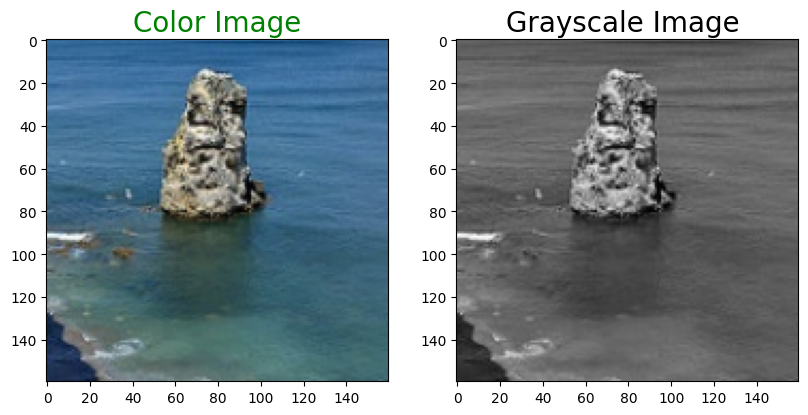

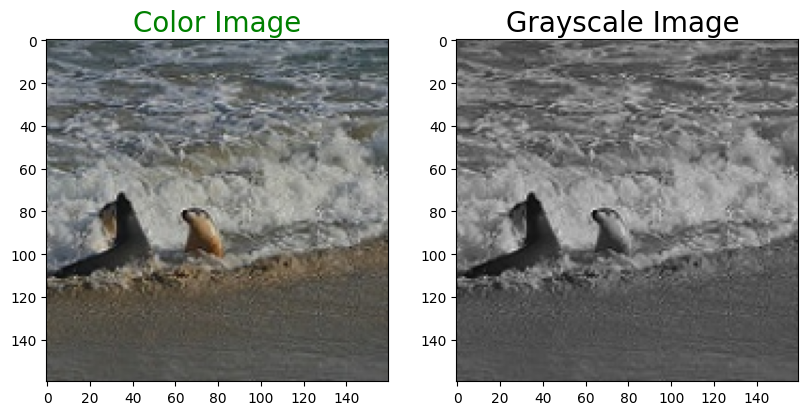

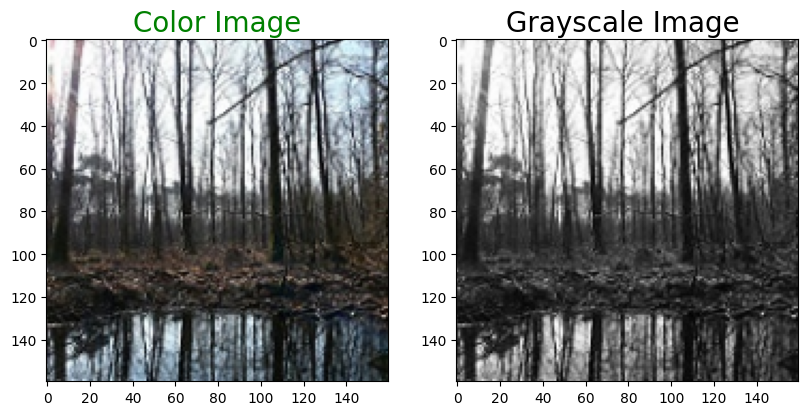

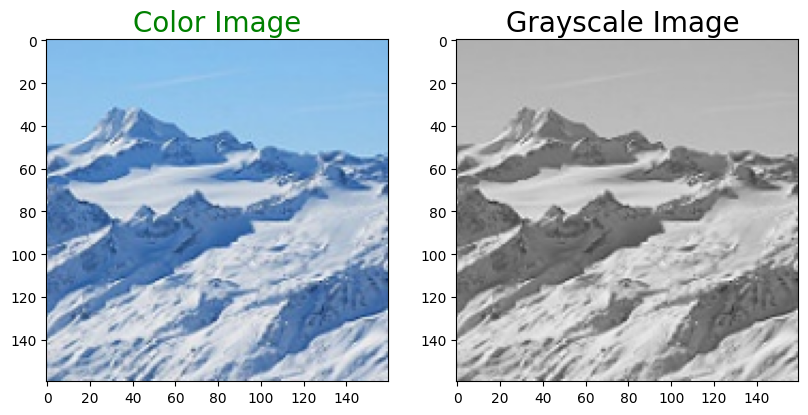

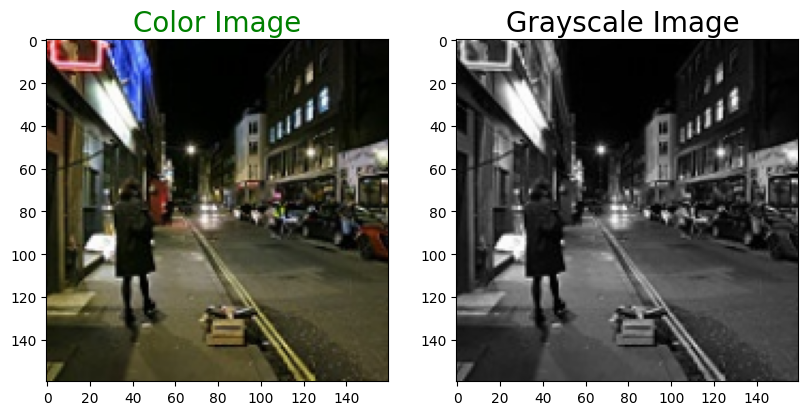

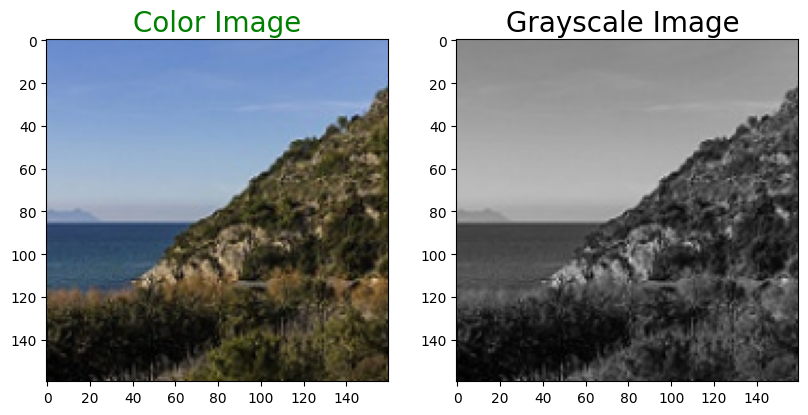

In [4]:
for i in range(10,18):
     plot_images(color_img[i],gray_img[i])

### Slicing and reshaping
Out of 5000 images I have sliced them to two part. train images consist 4000 images  while test images contains 1000 images.
After slicing the image array, I reshaped them so that images can be fed directly into our encoder network

In [5]:
# Splitting dataset into training and testing
total_images = len(gray_img)
split_point = int(total_images * 0.8)

train_gray_image = gray_img[:split_point]
train_color_image = color_img[:split_point]
test_gray_image = gray_img[split_point:]
test_color_image = color_img[split_point:]

train_g = np.reshape(train_gray_image, (len(train_gray_image), SIZE, SIZE, 3))
train_c = np.reshape(train_color_image, (len(train_color_image), SIZE, SIZE, 3))
test_g = np.reshape(test_gray_image, (len(test_gray_image), SIZE, SIZE, 3))
test_c = np.reshape(test_color_image, (len(test_color_image), SIZE, SIZE, 3))


# VAE Loss Function

In [6]:
# Define downsample and upsample functions
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = models.Sequential()
    downsample.add(layers.Conv2D(filters, kernel_size, padding='same', strides=2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, dropout=False):
    upsample = models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2))
    if dropout:
        upsample.add(layers.Dropout(0.2))
    upsample.add(layers.LeakyReLU())
    return upsample

In [7]:
from tensorflow.keras.layers import Layer, Input, Lambda 
# Custom KL divergence layer
class KLDivergenceLayer(Layer):
    def __init__(self, beta=0.001, **kwargs):
        super(KLDivergenceLayer, self).__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1) * -0.5
        kl_loss *= self.beta
        self.add_loss(kl_loss)
        return inputs

## Defining our model
Encoder layer of our model consist blocks of Convolution layer with different number of kernel and kernel_size. Here, Convolution is used for downsampling. Similary, Decoder layer of our model consist of transpose convolution layer with different kernel size. Here, Decoder layer upsample image downsampled by encoder. Since there is feature loss between the encoder and decoder layers so inorder to prevent feature loss i have concatenate corresponding encoder and decoder layers. Check U_Net architecture for better understanding......

In [8]:
from tensorflow.keras import layers, models
# VAE Model Definition
latent_dim = 100
inputs = Input(shape=(SIZE, SIZE, 3))
d1 = down(128, (3, 3), False)(inputs)
d2 = down(128, (3, 3), False)(d1)
d3 = down(256, (3, 3), True)(d2)
d4 = down(512, (3, 3), True)(d3)
d5 = down(512, (3, 3), True)(d4)

flatten = layers.Flatten()(d5)
dense = layers.Dense(256, activation='relu')(flatten)
z_mean = layers.Dense(latent_dim)(dense)
z_log_var = layers.Dense(latent_dim)(dense)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
z_mean, z_log_var = KLDivergenceLayer(beta=0.001)([z_mean, z_log_var])

# Decoder Definition
decoder_input = layers.Dense(256, activation='relu')(z)
decoder_dense = layers.Dense(512 * 5 * 5, activation='relu')(decoder_input)
reshape = layers.Reshape((5, 5, 512))(decoder_dense)

u1 = up(512, (3, 3), False)(reshape)
u1 = layers.concatenate([u1, d4])
u2 = up(256, (3, 3), False)(u1)
u2 = layers.concatenate([u2, d3])
u3 = up(128, (3, 3), False)(u2)
u3 = layers.concatenate([u3, d2])
u4 = up(128, (3, 3), False)(u3)
u4 = layers.concatenate([u4, d1])
u5 = up(64, (3, 3), False)(u4)

output_img = layers.Conv2D(3, (2, 2), strides=1, padding='same')(u5)

vae = models.Model(inputs, output_img)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='mse')  # Loss is MSE, KL handled by the layer
vae.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 80, 80,    │      3,584 │ input_layer[0][0] │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 40, 40,    │    147,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 20, 20,    │    296,192 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 10, 10,    │  1,182,208 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 5, 5, 512) │  2,361,856 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12800)     │          0 │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  3,277,056 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     25,700 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │     25,700 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 100)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     25,856 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 12800)     │  3,289,600 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 5, 512) │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 10, 10,    │  2,359,808 │ reshape[0][0]     │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 10,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 20, 20,    │  2,359,552 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 20, 20,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 40, 40,    │    589,952 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                 

 Total params: 16,387,979 (62.52 MB)

 Trainable params: 16,385,419 (62.51 MB)

 Non-trainable params: 2,560 (10.00 KB)

# Fitting the Model

In [9]:
class LossAndAccuracyCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.val_accuracy = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss = self.model.evaluate(test_g, test_c, verbose=0)
        pred = self.model.predict(test_g)
        tolerance = 0.05
        accuracy = np.mean(np.abs(pred - test_c) < tolerance)

        self.val_accuracy.append(accuracy)
        self.val_loss.append(test_loss)

        print(f"Epoch {epoch + 1}: Training Loss: {logs['loss']:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Val_Accuracy: {accuracy:.4f}")

# Instantiate the callback
loss_acc_callback = LossAndAccuracyCallback()
# Train the model
history = vae.fit(train_g, train_c, epochs=30, batch_size=50, verbose=1, callbacks=[LossAndAccuracyCallback()])




Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Epoch 1: Training Loss: 0.1154, Test Loss: 0.0631, Val_Accuracy: 0.1937
24/24 ━━━━━━━━━━━━━━━━━━━━ 283s 12s/step - loss: 0.1775
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Epoch 2: Training Loss: 0.0206, Test Loss: 0.0272, Val_Accuracy: 0.2769
24/24 ━━━━━━━━━━━━━━━━━━━━ 270s 11s/step - loss: 0.0240
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Epoch 3: Training Loss: 0.0155, Test Loss: 0.0206, Val_Accuracy: 0.3104
24/24 ━━━━━━━━━━━━━━━━━━━━ 273s 11s/step - loss: 0.0166
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Epoch 4: Training Loss: 0.0139, Test Loss: 0.0178, Val_Accuracy: 0.3335
24/24 ━━━━━━━━━━━━━━━━━━━━ 273s 11s/step - loss: 0.0142
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Epoch 5: Training Loss: 0.0127, Test Loss: 0.0159, Val_Accuracy: 0.3676
24/24 ━━━━━━━━━━━━━━━━━━━━ 274s 12s/step - loss: 0.0135
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Epoch 6: Training Loss: 0.0117, Test Loss: 0.0142, Val_Accur

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


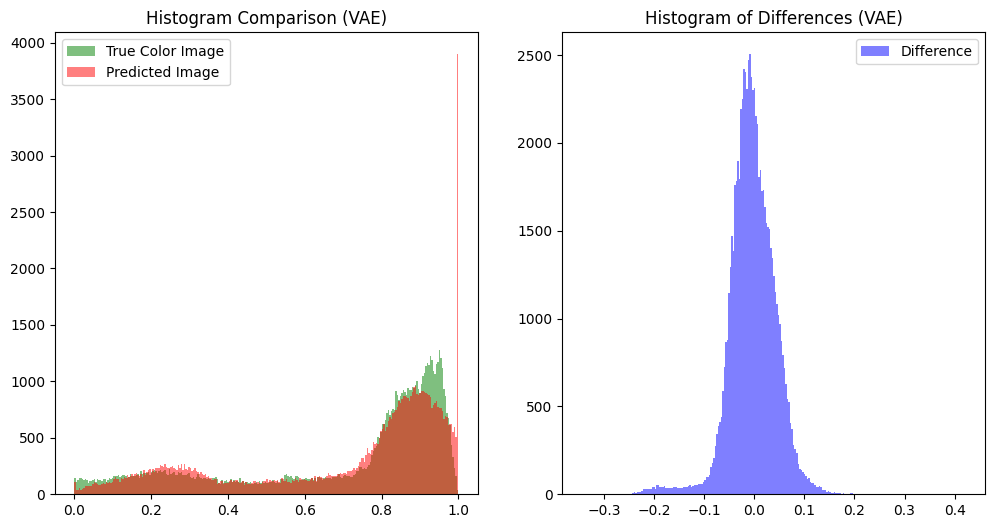

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


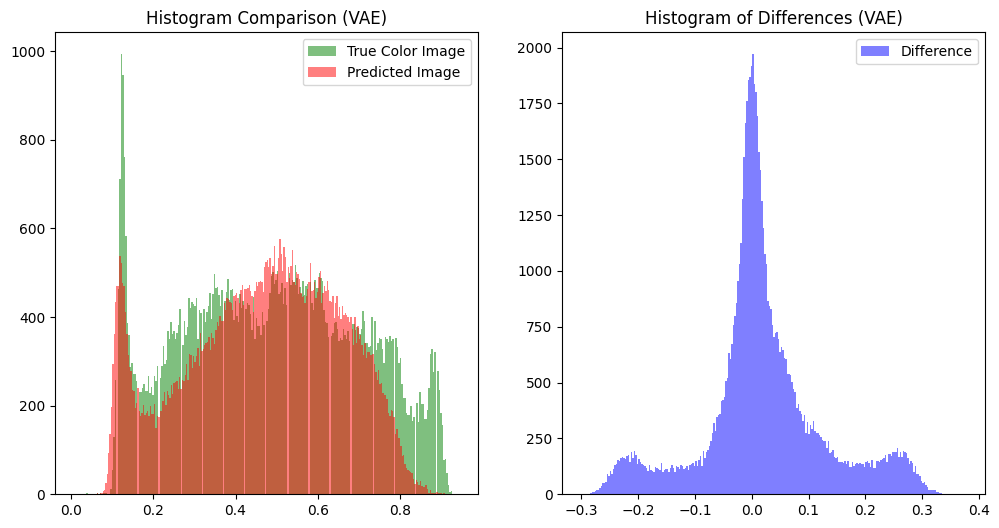

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


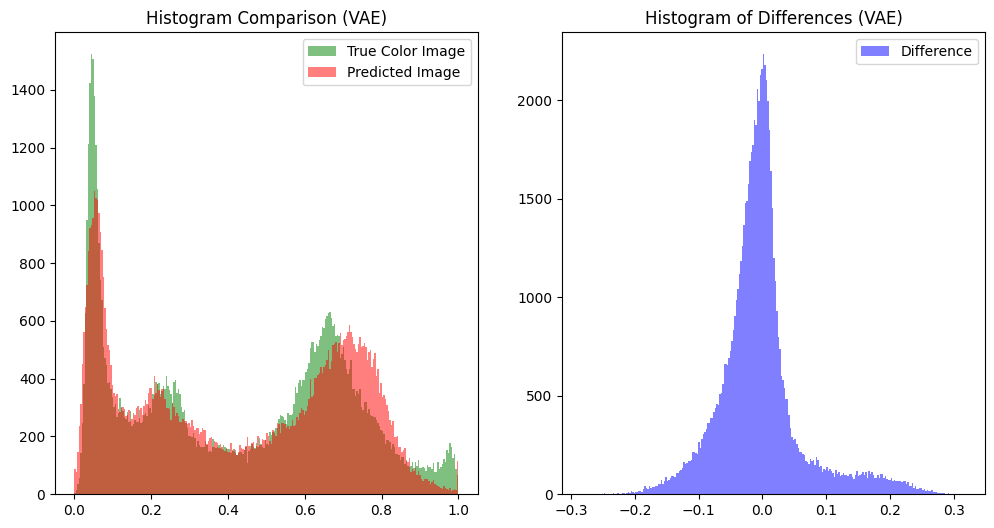

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


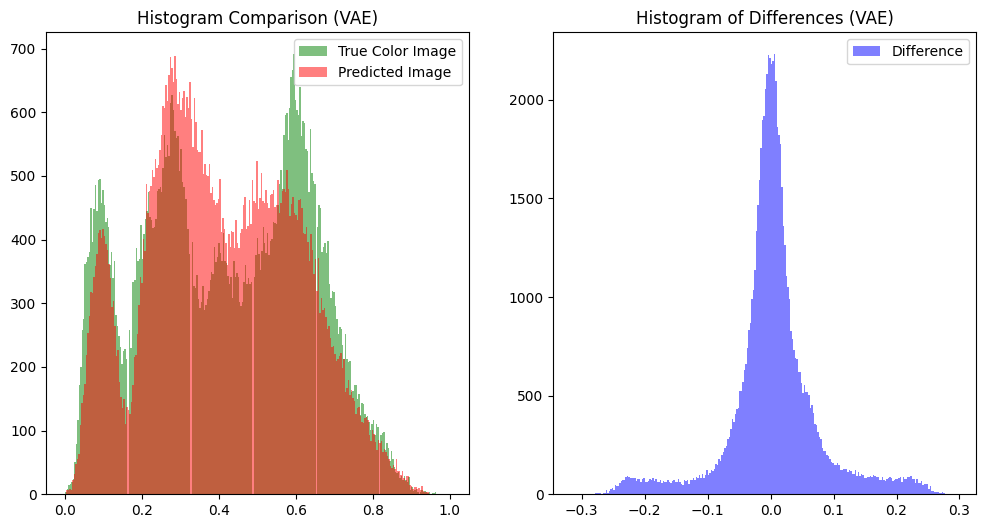

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


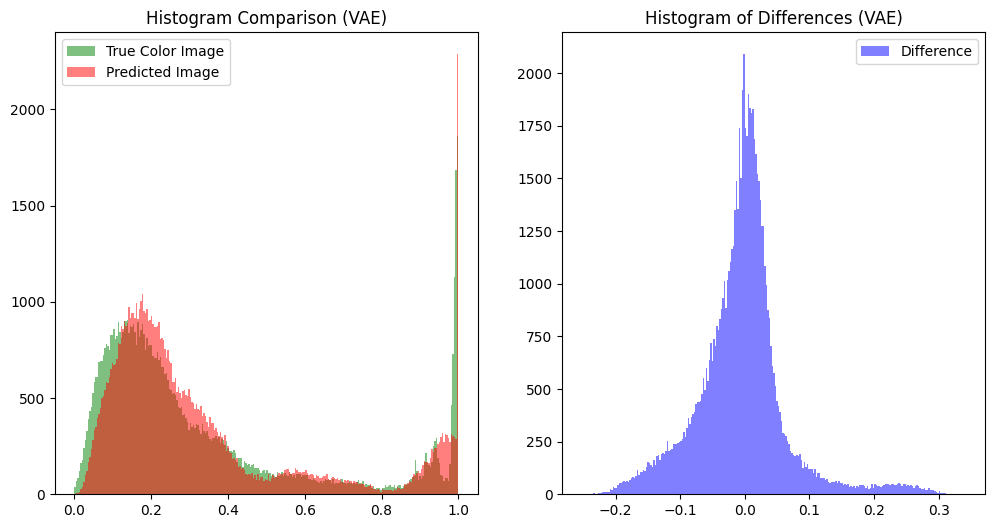

"# Plot Histogram Analysis for U-Net Model\nfor i in range(5):\n    grayscale_input = test_g[i].reshape(1, SIZE, SIZE, 3)\n    predicted_unet = np.clip(unet.predict(grayscale_input), 0.0, 1.0).reshape(SIZE, SIZE, 3)\n    plot_histogram_analysis(test_c[i], predicted_unet, 'U-Net')"

In [10]:
def plot_histogram_analysis(test_c, predicted, model_name):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(test_c.ravel(), bins=256, color='green', alpha=0.5, label='True Color Image')
    plt.hist(predicted.ravel(), bins=256, color='red', alpha=0.5, label='Predicted Image')
    plt.title(f'Histogram Comparison ({model_name})')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist((test_c - predicted).ravel(), bins=256, color='blue', alpha=0.5, label='Difference')
    plt.title(f'Histogram of Differences ({model_name})')
    plt.legend()

    plt.show()

# Plot Histogram Analysis for VAE Model
for i in range(5):
    grayscale_input = test_g[i].reshape(1, SIZE, SIZE, 3)
    predicted_vae = np.clip(vae.predict(grayscale_input), 0.0, 1.0).reshape(SIZE, SIZE, 3)
    plot_histogram_analysis(test_c[i], predicted_vae, 'VAE')

'''# Plot Histogram Analysis for U-Net Model
for i in range(5):
    grayscale_input = test_g[i].reshape(1, SIZE, SIZE, 3)
    predicted_unet = np.clip(unet.predict(grayscale_input), 0.0, 1.0).reshape(SIZE, SIZE, 3)
    plot_histogram_analysis(test_c[i], predicted_unet, 'U-Net')'''


In [11]:
# Plot Val_Accuracy vs. Val_Loss
'''plt.figure(figsize=(10, 6))
plt.plot(loss_acc_callback.val_loss, label='Val_Loss', marker='o')
plt.plot(loss_acc_callback.val_accuracy, label='Val_Accuracy', marker='o')
plt.title('Validation Loss and Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()'''

"plt.figure(figsize=(10, 6))\nplt.plot(loss_acc_callback.val_loss, label='Val_Loss', marker='o')\nplt.plot(loss_acc_callback.val_accuracy, label='Val_Accuracy', marker='o')\nplt.title('Validation Loss and Accuracy over Epochs')\nplt.xlabel('Epoch')\nplt.ylabel('Value')\nplt.legend()\nplt.grid(True)\nplt.show()"

# plotting colorized image along with grayscale and color image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


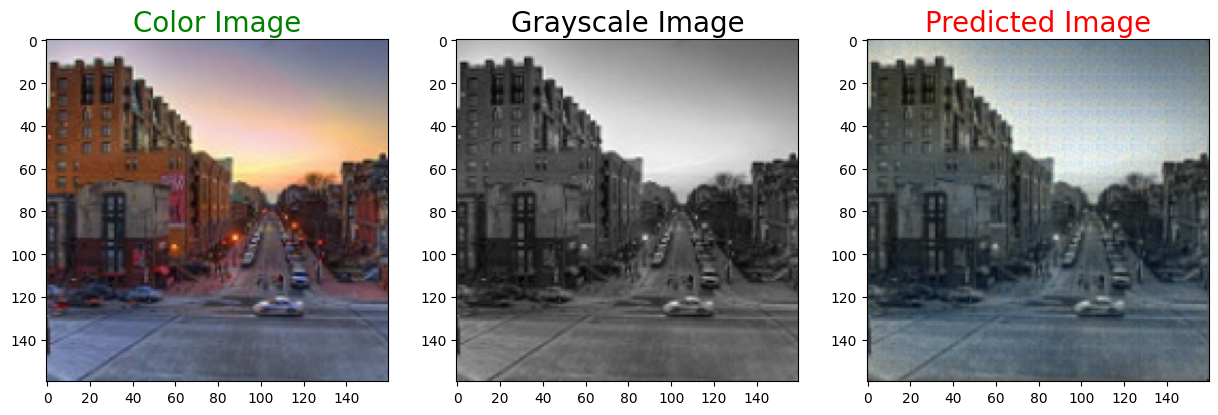

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


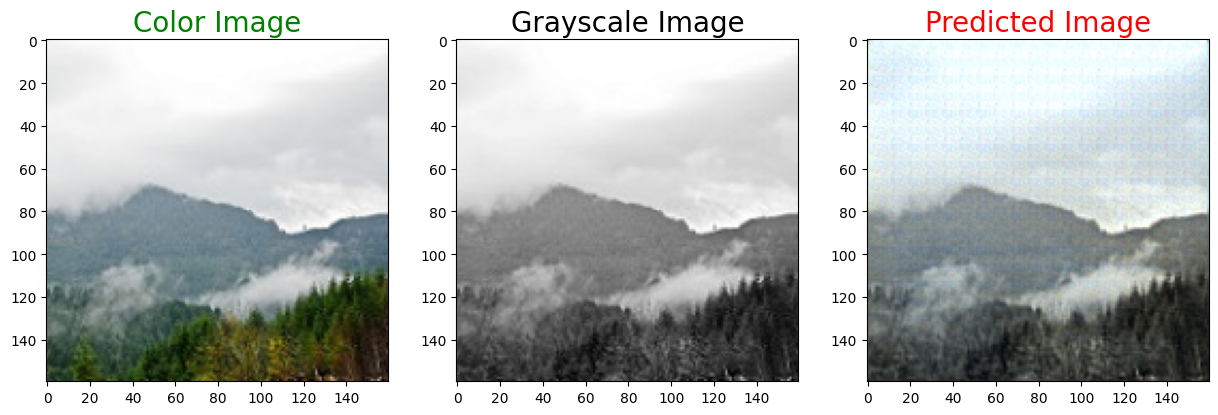

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


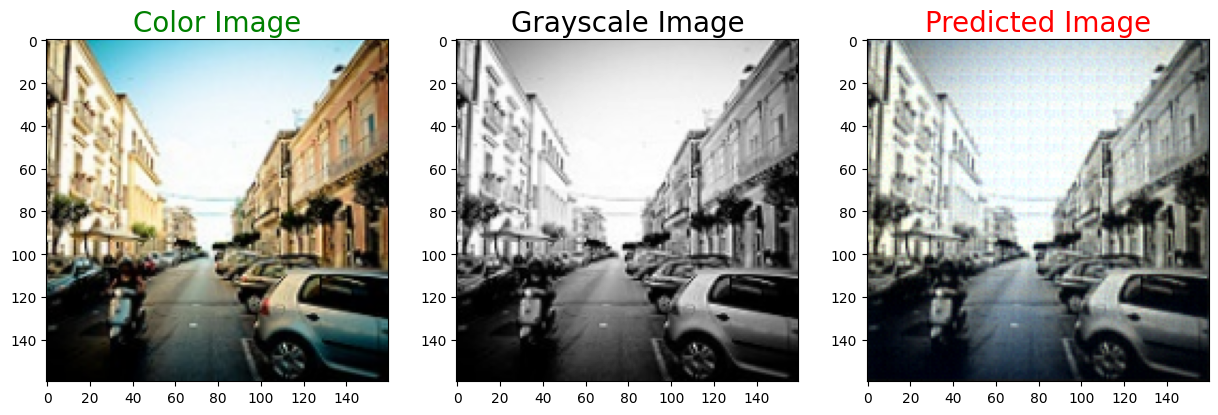

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


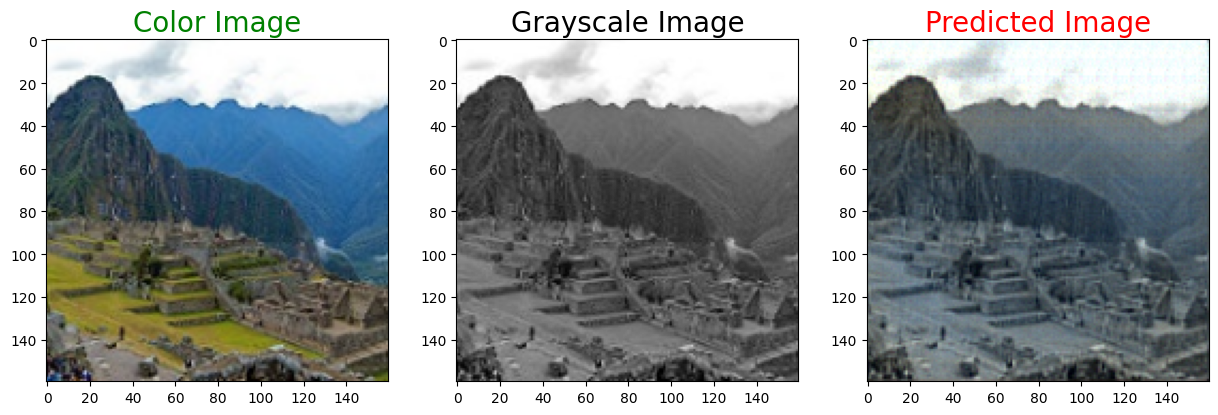

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


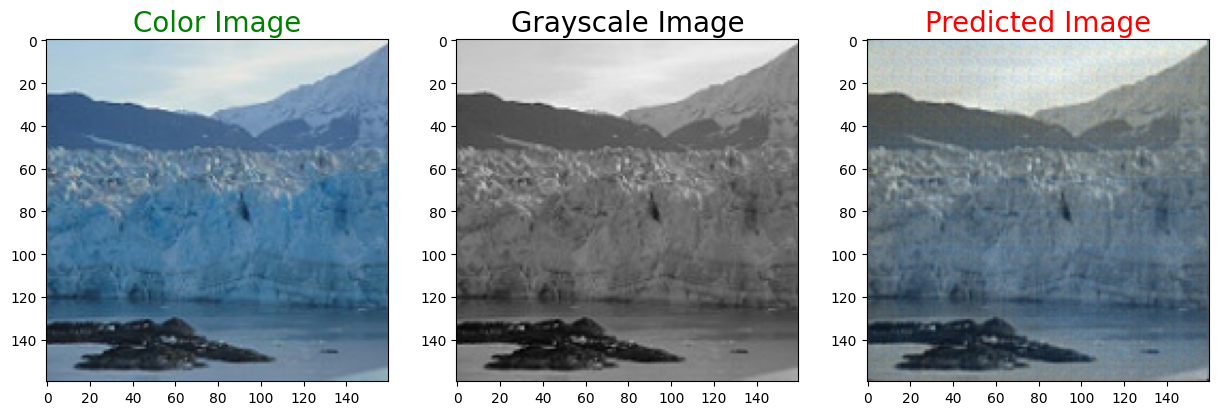

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


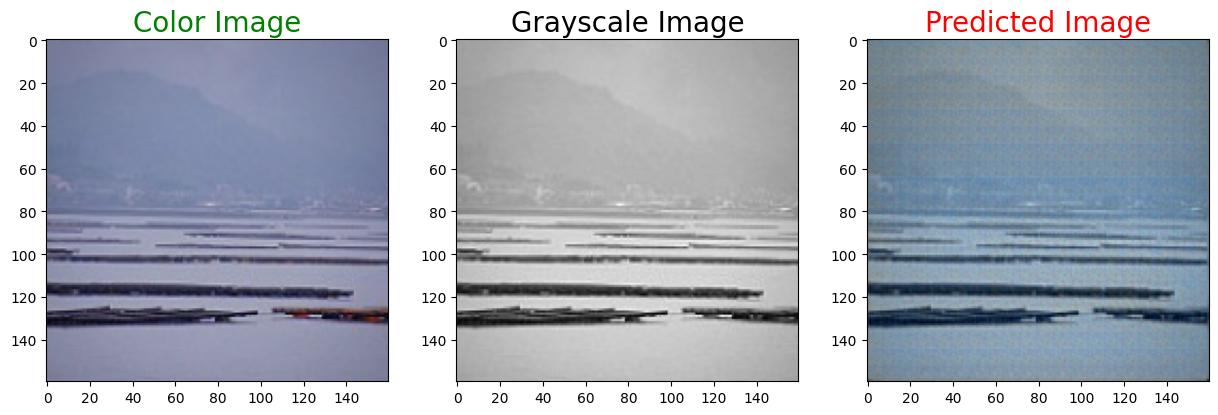

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


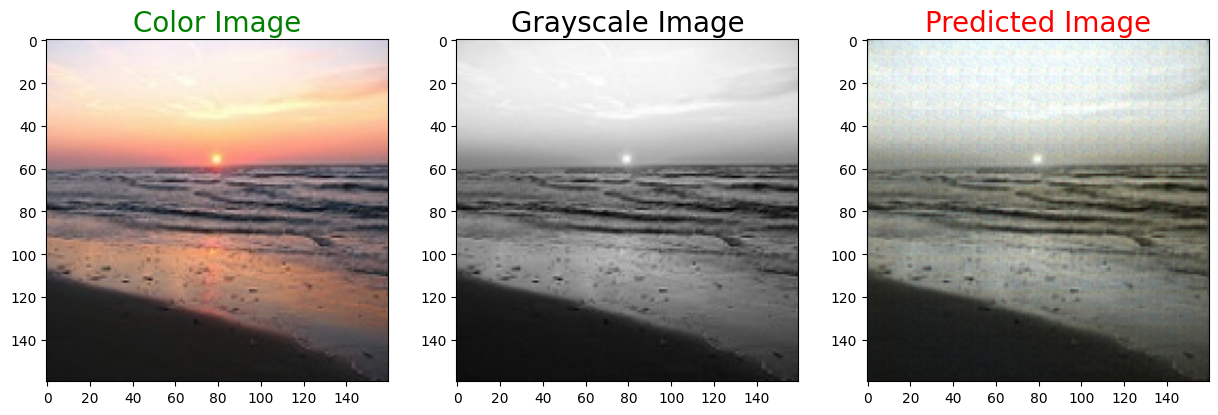

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


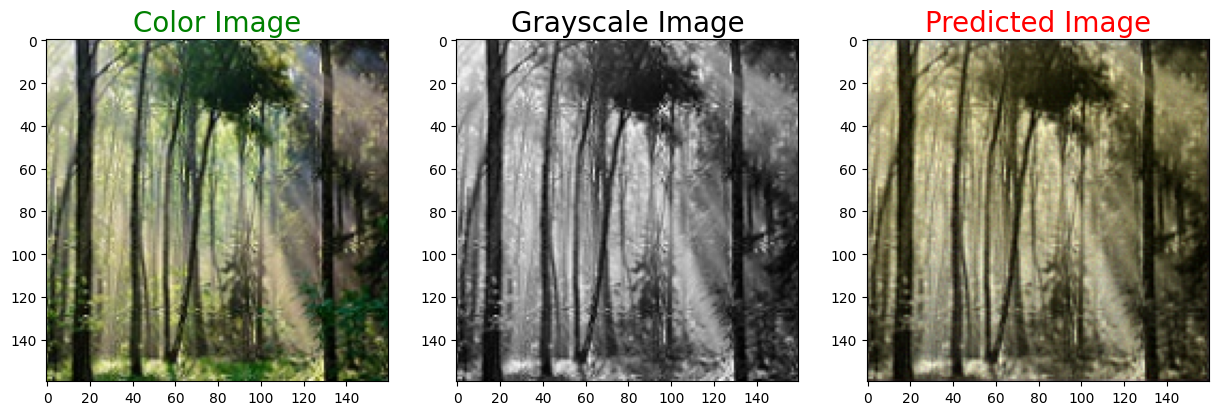

In [12]:
# Plot function
def plot_images(color, grayscale, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Color Image', color='green', fontsize=20)
    plt.imshow(color)
    
    plt.subplot(1, 3, 2)
    plt.title('Grayscale Image', color='black', fontsize=20)
    plt.imshow(grayscale, cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title('Predicted Image', color='red', fontsize=20)
    plt.imshow(predicted)
    plt.show()

# Predict and plot images
for i in range(10, 18):
    grayscale_input = test_g[i].reshape(1, SIZE, SIZE, 3)
    predicted = np.clip(vae.predict(grayscale_input), 0.0, 1.0).reshape(SIZE, SIZE, 3)
    plot_images(test_c[i], test_g[i][:, :, 0], predicted)

In [13]:
def evaluate_model_performance(model, test_g, test_c):
    psnr_values = []
    ssim_values = []

    for i in range(len(test_g):
        grayscale_input = test_g[i].reshape(1, SIZE, SIZE, 3)
        predicted = np.clip(model.predict(grayscale_input), 0.0, 1.0).reshape(SIZE, SIZE, 3)

        psnr = tf.image.psnr(predicted, test_c[i], max_val=1.0).numpy()
        ssim = tf.image.ssim(predicted, test_c[i], max_val=1.0).numpy()

        psnr_values.append(psnr)
        ssim_values.append(ssim)

    return np.mean(psnr_values), np.mean(ssim_values)

# Evaluate VAE Model
vae_psnr, vae_ssim = evaluate_model_performance(vae, test_g, test_c)
print(f"VAE Model - PSNR: {vae_psnr}, SSIM: {vae_ssim}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from scipy.linalg import sqrtm
import numpy as np

# Load the InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(SIZE, SIZE, 3))
model = Model(inputs=inception_model.input, outputs=inception_model.get_layer('avg_pool').output)

def get_activations(images):
    # Preprocess images
    images = preprocess_input(images)
    # Get the activations from the InceptionV3 model
    activations = model.predict(images)
    return activations

# Generate features for real and fake images
real_activations = get_activations(test_c)
generated_activations = get_activations(vae.predict(test_g))
from numpy import cov, trace, iscomplexobj
from numpy import sqrtm

def calculate_fid(act1, act2):
    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # Calculate sqrt of product between covariances
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate FID score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
fid_score = calculate_fid(real_activations, generated_activations)
print(f'FID Score for VAE: {fid_score}')


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution